In [2]:
!pip install joblib==1.5.1


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from joblib import load

zsh:1: command not found: pip


# Understanding the Model

In [3]:
df = pd.read_csv("historical.csv")

df.head()

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-10,1,3.28,...,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-11,2,3.35,...,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-12,3,3.35,...,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-13,4,3.48,...,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-14,5,3.50,...,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk


In [4]:
print(f"Shape of the database: {df.shape}")
print()
print(df.dtypes)

Shape of the database: (2100, 25)

baby_id                         object
name                            object
gender                          object
gestational_age_weeks          float64
birth_weight_kg                float64
birth_length_cm                float64
birth_head_circumference_cm    float64
date                            object
age_days                         int64
weight_kg                      float64
length_cm                      float64
head_circumference_cm          float64
temperature_c                  float64
heart_rate_bpm                   int64
respiratory_rate_bpm             int64
oxygen_saturation                int64
feeding_type                    object
feeding_frequency_per_day        int64
urine_output_count               int64
stool_count                      int64
jaundice_level_mg_dl           float64
apgar_score                    float64
immunizations_done              object
reflexes_normal                 object
risk_level                   

The database contains 2100 rows and 25 columns. Specify column names

then next part is highlighting the duplicate names/id numbers

### Handling Null Values

In [5]:
df.isna().sum()

baby_id                           0
name                              0
gender                            0
gestational_age_weeks             0
birth_weight_kg                   0
birth_length_cm                   0
birth_head_circumference_cm       0
date                              0
age_days                          0
weight_kg                         0
length_cm                         0
head_circumference_cm             0
temperature_c                     0
heart_rate_bpm                    0
respiratory_rate_bpm              0
oxygen_saturation                 0
feeding_type                      0
feeding_frequency_per_day         0
urine_output_count                0
stool_count                       0
jaundice_level_mg_dl              0
apgar_score                    2030
immunizations_done                0
reflexes_normal                   0
risk_level                        0
dtype: int64

then define what Apgar is and why it's probably null

# Dissecting the Model

In [6]:
# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

pipe

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


explain if these parameters are tuned or default

describe the parameters per step

In [7]:
pipe.named_steps['preprocess'].transformers_


[('num',
  StandardScaler(),
  ['gestational_age_weeks',
   'birth_weight_kg',
   'birth_length_cm',
   'birth_head_circumference_cm',
   'age_days',
   'weight_kg',
   'length_cm',
   'head_circumference_cm',
   'temperature_c',
   'heart_rate_bpm',
   'respiratory_rate_bpm',
   'oxygen_saturation',
   'feeding_frequency_per_day',
   'urine_output_count',
   'stool_count',
   'jaundice_level_mg_dl']),
 ('cat',
  OneHotEncoder(drop='if_binary', handle_unknown='ignore'),
  ['gender', 'feeding_type', 'immunizations_done', 'reflexes_normal'])]

note that the 3 columns are missing from the transformers in the preprocessing step of the old model:
- baby_id
- name
- date
- apgar_score

This would probably suggest that these columns were dropped before loading the data into the model. The columns for Baby ID and name may have been dropped because these columns served as unque identifiers or labels of the data points, not a feature or column the model needs to identify patterns. 

Then, explain date (still unsure now why the dropped it)

On the other hand, the column for apgar score may have been dropped because it contains 2030 missing values. Dropping rows will empty values would reduce the database to 70 data points, which is not enough to train the model. Therefore, Data Monitors may have decided to drop the column instead to preserve majority of the data.

In [8]:
target_col = "risk_level"
dropped_col = ["baby_id", "name", "date", "apgar_score"]
X = df.drop(columns=[target_col])
X = X.drop(columns=dropped_col)
y = df[target_col]

In [9]:
# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=0
)
# (Resulting split = 60% train, 20% val, 20% test)

In [10]:
model = pipe.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
test_acc = model.score(X_test, y_test)

In [11]:
C = model["clf"].get_params()["C"]
print(f"C={C} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

C=1.0 | Train=0.9278 | Val=0.9310 | Test=0.9095


### Chabby suggests K-fold due to the +- 1% accuracy description in case facts

but can't fully recreate it so i don't know


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=10)
print(scores.mean(), scores.std())


0.9223809523809525 0.009047619047619061


In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("Mean:", scores.mean(), "Std:", scores.std())


Mean: 0.9233333333333332 Std: 0.01865062478815824


# Remove Later

In [22]:
y_pred = model.predict(X)

y_pred

array(['Healthy', 'At Risk', 'Healthy', ..., 'Healthy', 'Healthy',
       'Healthy'], shape=(2100,), dtype=object)

In [23]:
y

0       At Risk
1       At Risk
2       Healthy
3       Healthy
4       At Risk
         ...   
2095    Healthy
2096    Healthy
2097    Healthy
2098    Healthy
2099    Healthy
Name: risk_level, Length: 2100, dtype: object

In [24]:
print(f"F1 Score: {f1_score(y, y_pred, pos_label='At Risk'):.4f}")
print(classification_report(y, y_pred))

F1 Score: 0.6815
              precision    recall  f1-score   support

     At Risk       0.78      0.61      0.68       278
     Healthy       0.94      0.97      0.96      1822

    accuracy                           0.92      2100
   macro avg       0.86      0.79      0.82      2100
weighted avg       0.92      0.92      0.92      2100



### misclassified babies

# Trying to recreate the Accuracy in the Model Specifications

In [22]:
model  # prints the whole graph

# Or just names
print(model.named_steps.keys())

# Params on each step
print(model.named_steps['preprocess'].get_params())
print(model.named_steps['clf'].get_params())


dict_keys(['preprocess', 'clf'])
{'force_int_remainder_cols': 'deprecated', 'n_jobs': None, 'remainder': 'drop', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('num', StandardScaler(), <sklearn.compose._column_transformer.make_column_selector object at 0x759615ad2990>), ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), <sklearn.compose._column_transformer.make_column_selector object at 0x7596159c2ff0>)], 'verbose': False, 'verbose_feature_names_out': True, 'num': StandardScaler(), 'cat': OneHotEncoder(drop='if_binary', handle_unknown='ignore'), 'num__copy': True, 'num__with_mean': True, 'num__with_std': True, 'cat__categories': 'auto', 'cat__drop': 'if_binary', 'cat__dtype': <class 'numpy.float64'>, 'cat__feature_name_combiner': 'concat', 'cat__handle_unknown': 'ignore', 'cat__max_categories': None, 'cat__min_frequency': None, 'cat__sparse_output': True}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 

    Note sure if this is correct though because the parameters are already set

### L2

/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 

C=1e-08    | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1e-05    | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.001    | Train=0.9286 | Val=1.0000 | Test=0.8571
C=0.1      | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.2      | Train=0.9524 | Val=1.0000 | Test=0.8571
C=0.4      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.75     | Train=1.0000 | Val=1.0000 | Test=0.8571
C=1        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1.5      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=3        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=5        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=15       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=20       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=100      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=300      | Train=1.0000 | Val=0.9286 | Test=0.8571
C=10000    | Train=1.0000 | Val=0.9286 | Test=0.8571


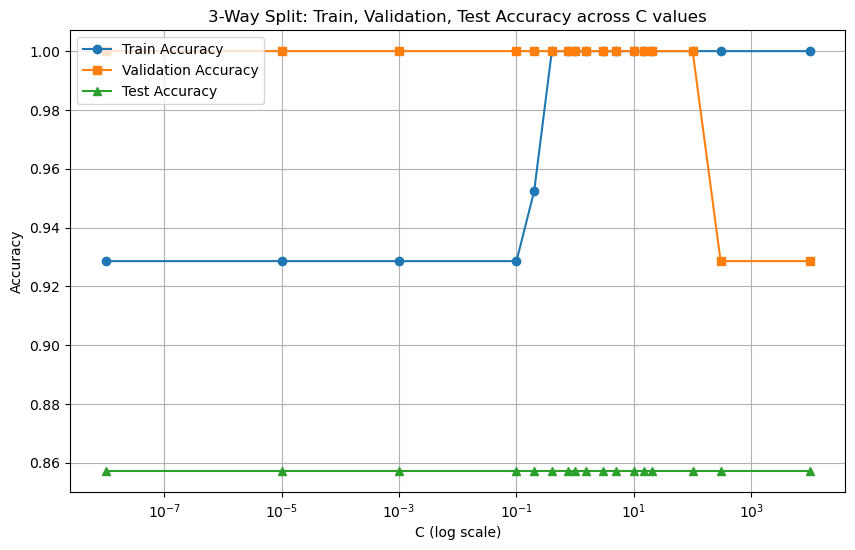

In [ ]:
# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

df = pd.read_csv("historical.csv")
df['apgar_score'] = df['apgar_score'].ffill()

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split: Train, Validation, Test Accuracy across C values")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
model_bestC = clone(pipe).set_params(clf__C=1, clf__max_iter=2000)
model_bestC.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x759615f2f860>),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x759615f2f0b0>)])),
                ('clf',
                 LogisticRegression(C=1, max_iter=2000, random_state=0))])

In [28]:
df.iloc[6]

baby_id                              B001
name                                 Sara
gender                             Female
gestational_age_weeks                40.2
birth_weight_kg                       3.3
birth_length_cm                      50.0
birth_head_circumference_cm          31.9
date                           2024-12-16
age_days                                7
weight_kg                            3.53
length_cm                            50.9
head_circumference_cm                32.0
temperature_c                        37.0
heart_rate_bpm                        147
respiratory_rate_bpm                   36
oxygen_saturation                      98
feeding_type                      Formula
feeding_frequency_per_day              11
urine_output_count                      8
stool_count                             1
jaundice_level_mg_dl                  4.0
apgar_score                           7.0
immunizations_done                     No
reflexes_normal                   

In [ ]:
df.iloc[[5]]

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal
5,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-15,6,3.46,...,37,97,Mixed,10,6,0,10.1,7.0,No,Yes


In [40]:
df.iloc[[41]]

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
41,B002,Nicole,Female,39.4,3.15,50.1,32.0,2025-08-08,12,3.5,...,96,Mixed,8,6,5,3.2,7.0,No,Yes,Healthy


In [34]:
model_bestC.predict(X.iloc[[5]])

array(['At Risk'], dtype=object)

In [39]:
model_bestC.predict(X.iloc[[41]])

array(['Healthy'], dtype=object)

### L1

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.6.1. This might lead to breaking code o

C=1e-08    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=1e-05    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.001    | Train=0.8651 | Val=0.8667 | Test=0.8762


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.1      | Train=0.9183 | Val=0.9357 | Test=0.9214


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.2      | Train=0.9143 | Val=0.9405 | Test=0.9214


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.4      | Train=0.9167 | Val=0.9429 | Test=0.9190


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.75     | Train=0.9198 | Val=0.9429 | Test=0.9167


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1        | Train=0.9222 | Val=0.9405 | Test=0.9119


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1.5      | Train=0.9270 | Val=0.9357 | Test=0.9095


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=3        | Train=0.9595 | Val=0.9333 | Test=0.9000


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=5        | Train=0.9738 | Val=0.9286 | Test=0.8929


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10       | Train=0.9770 | Val=0.9190 | Test=0.8881


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=15       | Train=0.9817 | Val=0.9167 | Test=0.8833


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=20       | Train=0.9825 | Val=0.9071 | Test=0.8833


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=100      | Train=0.9841 | Val=0.9071 | Test=0.8857


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=300      | Train=0.9841 | Val=0.8976 | Test=0.8857


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10000    | Train=0.9841 | Val=0.8905 | Test=0.8810


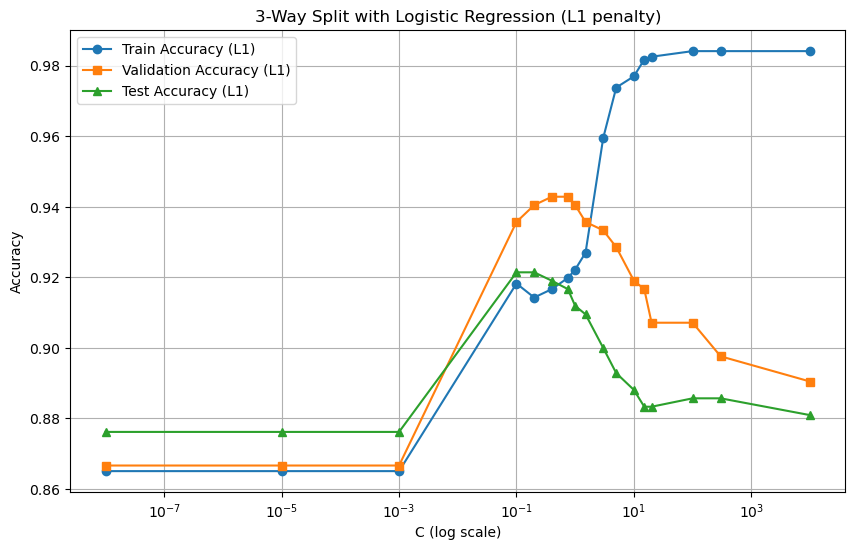

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from joblib import load
import pandas as pd

# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("ML Lab 2/model.joblib")

df = pd.read_csv("ML Lab 2/historical.csv")
df = df.drop(columns=['apgar_score'])

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values (L1)
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(
        clf__penalty="l1",
        clf__solver="saga",   # saga supports L1 + multiclass
        clf__C=c_val,
        clf__max_iter=5000    # bump iterations for convergence
    )
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(
        clf__penalty="l1",
        clf__solver="saga",
        clf__C=c_val,
        clf__max_iter=5000
    )
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy (L1)")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy (L1)")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy (L1)")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split with Logistic Regression (L1 penalty)")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
nan_counts = df.isna().sum()
nan_counts

baby_id                           0
name                              0
gender                            0
gestational_age_weeks             0
birth_weight_kg                   0
birth_length_cm                   0
birth_head_circumference_cm       0
date                              0
age_days                          0
weight_kg                         0
length_cm                         0
head_circumference_cm             0
temperature_c                     0
heart_rate_bpm                    0
respiratory_rate_bpm              0
oxygen_saturation                 0
feeding_type                      0
feeding_frequency_per_day         0
urine_output_count                0
stool_count                       0
jaundice_level_mg_dl              0
apgar_score                    2030
immunizations_done                0
reflexes_normal                   0
risk_level                        0
dtype: int64

In [37]:
df = df.drop(columns=['baby_id', 'name'])

### L2 without baby id and name

/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 

C=1e-08    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=1e-05    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.001    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.1      | Train=0.9183 | Val=0.9452 | Test=0.9214
C=0.2      | Train=0.9198 | Val=0.9476 | Test=0.9190
C=0.4      | Train=0.9214 | Val=0.9452 | Test=0.9214
C=0.75     | Train=0.9214 | Val=0.9452 | Test=0.9190
C=1        | Train=0.9206 | Val=0.9452 | Test=0.9190
C=1.5      | Train=0.9206 | Val=0.9452 | Test=0.9214
C=3        | Train=0.9206 | Val=0.9476 | Test=0.9190
C=5        | Train=0.9206 | Val=0.9476 | Test=0.9190
C=10       | Train=0.9206 | Val=0.9452 | Test=0.9190
C=15       | Train=0.9198 | Val=0.9452 | Test=0.9190
C=20       | Train=0.9198 | Val=0.9452 | Test=0.9190
C=100      | Train=0.9183 | Val=0.9429 | Test=0.9167
C=300      | Train=0.9190 | Val=0.9429 | Test=0.9143
C=10000    | Train=0.9190 | Val=0.9429 | Test=0.9143


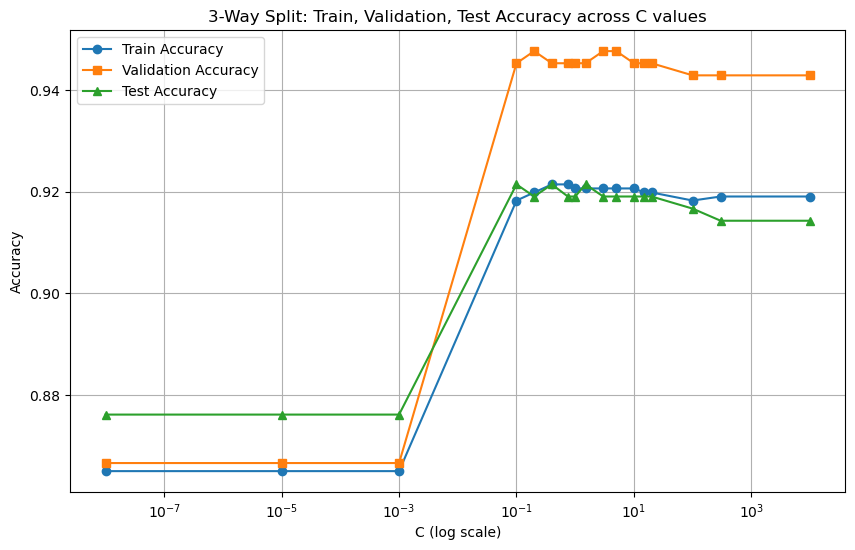

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from joblib import load
import pandas as pd

# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

df = pd.read_csv("historical.csv")
df['apgar_score'] = df['apgar_score'].ffill()
df = df.drop(columns=['baby_id', 'name', 'date'])

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split: Train, Validation, Test Accuracy across C values")
plt.legend()
plt.grid(True)
plt.show()


# EDA testing

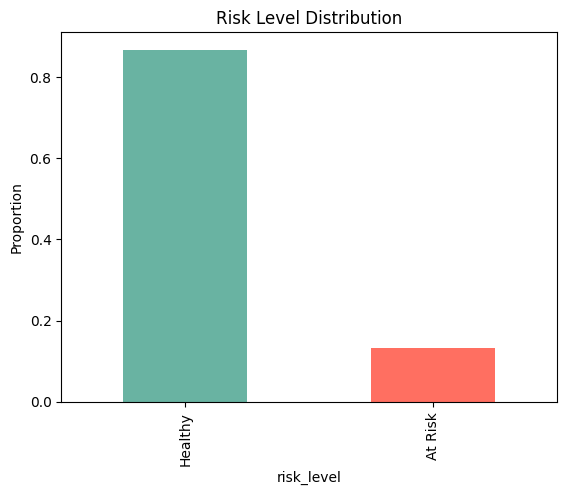

In [4]:
df['risk_level'].value_counts(normalize=True).plot(kind='bar', color=['#69b3a2','#ff6f61'])
plt.title('Risk Level Distribution')
plt.ylabel('Proportion')
plt.show()


/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3373699129.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3373699129.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3373699129.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3373699129.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'ti

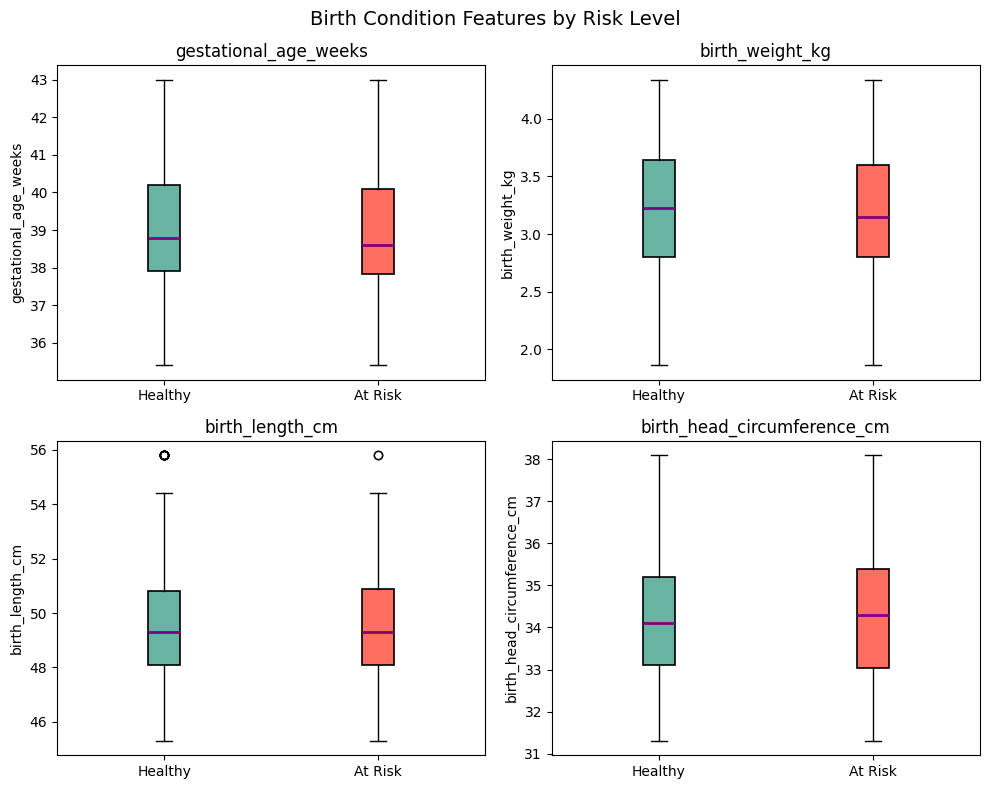

In [37]:
birth_cols = ['gestational_age_weeks','birth_weight_kg','birth_length_cm','birth_head_circumference_cm']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(birth_cols):
    healthy = df.loc[df['risk_level']=='Healthy', col]
    risky   = df.loc[df['risk_level']=='At Risk', col]

    box = axes[i].boxplot(
        [healthy, risky],
        patch_artist=True,  # enable fill
        labels=['Healthy','At Risk'],
        medianprops=dict(color='#800080', linewidth=2)  # bold purple median
    )

    # Fill colors
    colors = ['#69b3a2', '#ff6f61']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.2)

    # Whiskers, caps, and fliers
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1)
    for cap in box['caps']:
        cap.set(color='black', linewidth=1)
    for flier in box['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

    axes[i].set_title(col)
    axes[i].set_ylabel(col)

fig.suptitle('Birth Condition Features by Risk Level', fontsize=14)
plt.tight_layout()
plt.show()

The boxplots show that At Risk infants tend to have slightly lower gestational ages and birth weights compared to healthy babies, though the overlap between groups is substantial. Birth length and head circumference are nearly identical, suggesting that overall size at birth does not strongly distinguish risk status. This indicates that neonatal risk in the dataset is not determined solely by prematurity or underweight conditions but likely by postnatal physiological factors captured in daily monitoring. The result supports the dataset’s fairness and balance—showing that both groups begin from comparable birth baselines, and that subsequent differences in vitals and growth, rather than initial size, drive risk classification.

/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3259160125.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3259160125.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3259160125.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/3259160125.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'ti

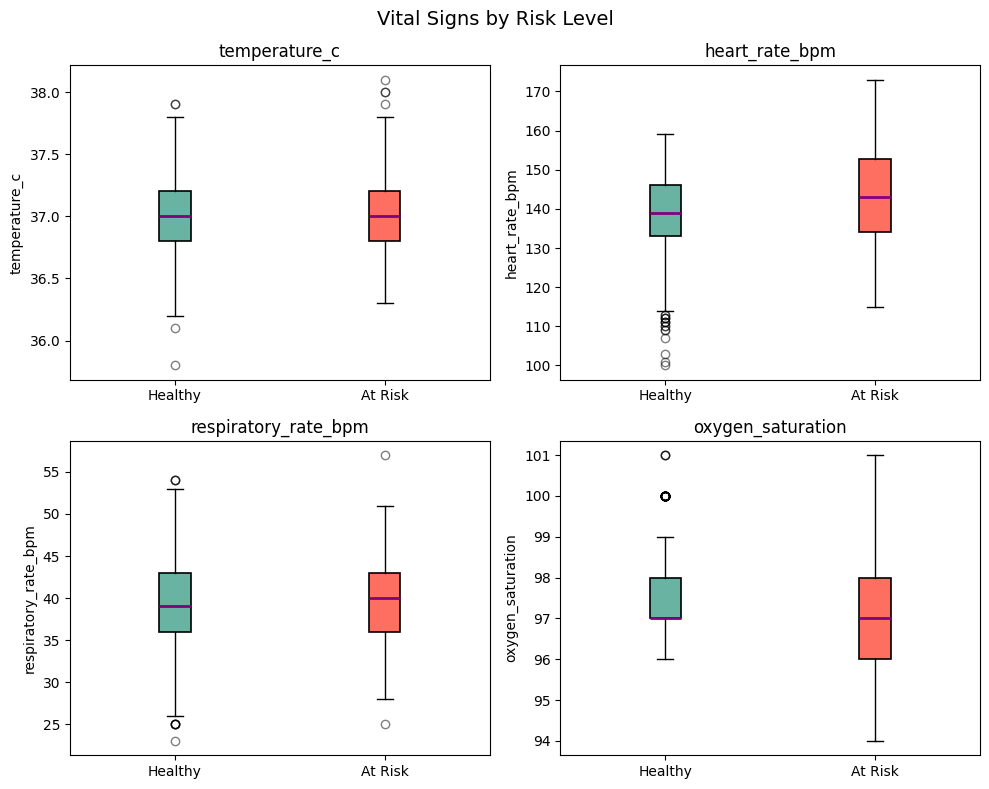

In [38]:
vitals = ['temperature_c','heart_rate_bpm','respiratory_rate_bpm','oxygen_saturation']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(vitals):
    h = df.loc[df['risk_level']=='Healthy', col]
    r = df.loc[df['risk_level']=='At Risk', col]

    box = axes[i].boxplot(
        [h, r],
        patch_artist=True,
        labels=['Healthy','At Risk'],
        medianprops=dict(color='#800080', linewidth=2)
    )

    colors = ['#69b3a2', '#ff6f61']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.2)

    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1)
    for cap in box['caps']:
        cap.set(color='black', linewidth=1)
    for flier in box['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

    axes[i].set_title(col)
    axes[i].set_ylabel(col)

fig.suptitle('Vital Signs by Risk Level', fontsize=14)
plt.tight_layout()
plt.show()

The boxplots show that At Risk infants tend to exhibit slightly higher body temperatures and heart rates, along with marginally lower oxygen saturation compared to healthy babies. Respiratory rates are similar between groups but display wider variability among at-risk infants, suggesting less stable breathing patterns. The overlap between distributions implies that no single vital sign defines risk on its own; rather, risk arises from subtle deviations across multiple physiological measures. These findings support the model’s design focus on multivariate monitoring—detecting risk through combined shifts in temperature, heart rate, and oxygen saturation rather than relying on any single clinical threshold.

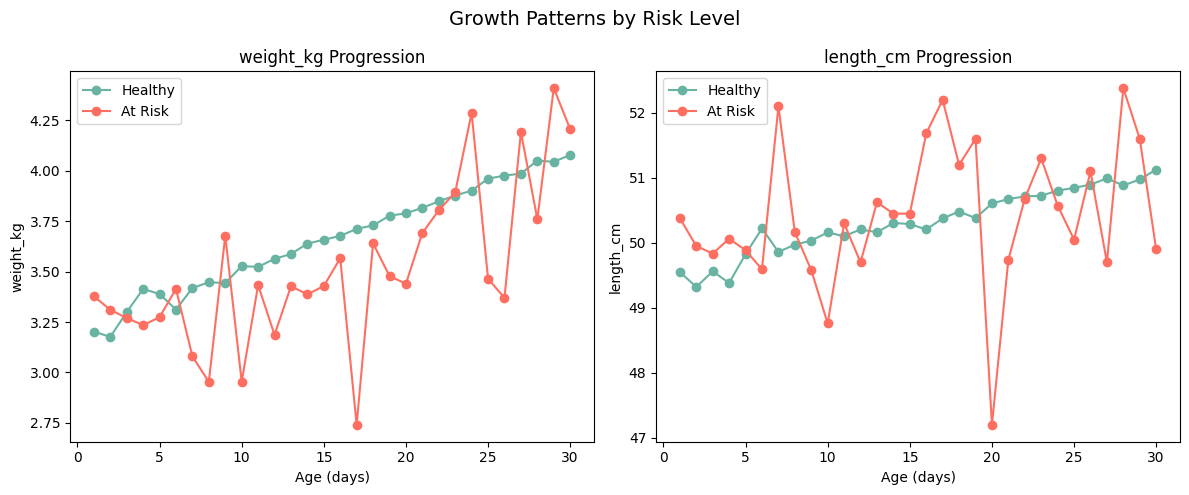

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, y in zip(axes, ['weight_kg','length_cm']):
    for label,color in zip(['Healthy','At Risk'],['#69b3a2','#ff6f61']):
        subset = df[df['risk_level']==label]
        grouped = subset.groupby('age_days')[y].mean()
        ax.plot(grouped.index, grouped.values, marker='o', color=color, label=f'{label}')
    ax.set_title(f'{y} Progression')
    ax.set_xlabel('Age (days)')
    ax.set_ylabel(y)
    ax.legend()

fig.suptitle('Growth Patterns by Risk Level', fontsize=14)
plt.tight_layout()
plt.show()


The growth curves show clear divergence between Healthy and At-Risk infants over the first 30 days. On average, healthy babies display a steady upward trend in both weight and length, indicating consistent daily growth. In contrast, at-risk infants exhibit more erratic progress and flatter overall trajectories, suggesting irregular or delayed development. Because each line represents the mean value per group per day, the visualization captures population-level patterns rather than individual cases. These trends reinforce that growth dynamics—rather than initial birth size—play a major role in identifying risk, emphasizing the dataset’s focus on ongoing physiological monitoring over static birth metrics.

/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/199513562.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot([h, r],
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/199513562.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot([h, r],
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/199513562.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot([h, r],
/var/folders/db/ggx093sn7jd57knx244_768r0000gn/T/ipykernel_38625/199513562.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has

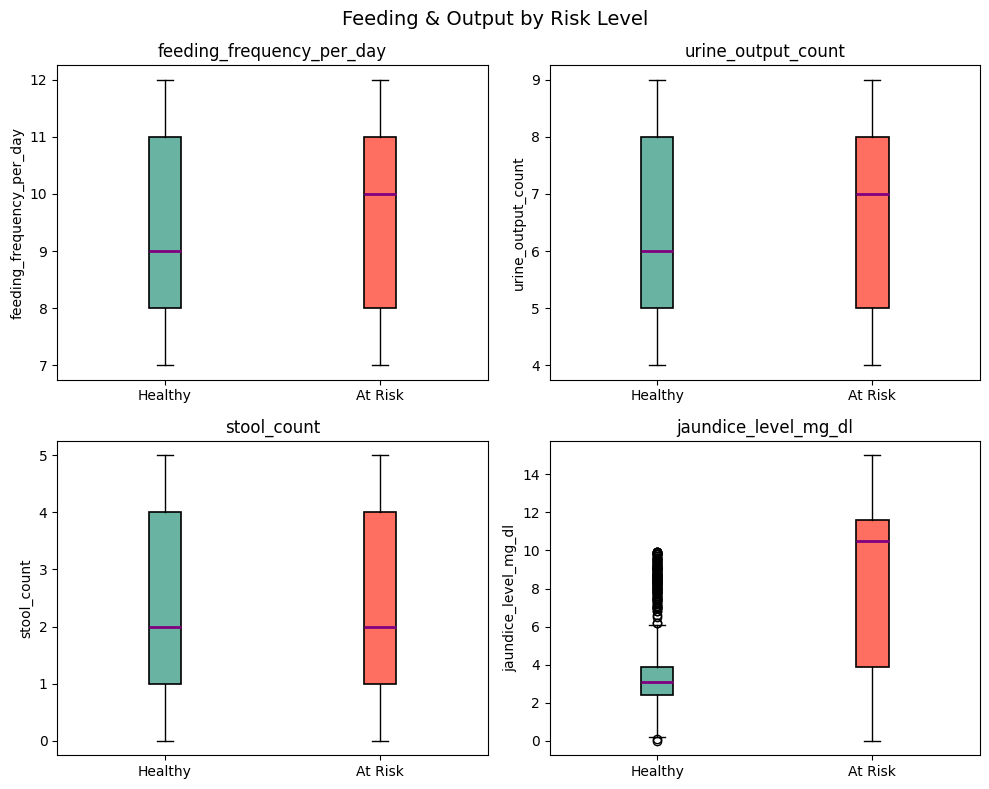

In [35]:
num_beh = ['feeding_frequency_per_day','urine_output_count','stool_count','jaundice_level_mg_dl']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(num_beh):
    h = df.loc[df['risk_level']=='Healthy', col]
    r = df.loc[df['risk_level']=='At Risk', col]
    
    # Create filled boxplots
    box = axes[i].boxplot([h, r],
                          patch_artist=True,           # allows color fill
                          labels=['Healthy','At Risk'],
                          medianprops=dict(color='#800080', linewidth=2))  # bold orange median
    
    # Set box fill colors
    colors = ['#69b3a2', '#ff6f61']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')       # optional: bold border
        patch.set_linewidth(1.2)
    
    # Optional: customize whiskers and caps
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1)
    for cap in box['caps']:
        cap.set(color='black', linewidth=1)
    
    axes[i].set_title(col)
    axes[i].set_ylabel(col)

fig.suptitle('Feeding & Output by Risk Level', fontsize=14)
plt.tight_layout()
plt.show()


The feeding and output plots reveal that At Risk infants tend to have slightly lower stool and urine output consistency, paired with significantly higher jaundice levels. Feeding frequency appears similar across groups, suggesting that feeding behavior alone is not a direct indicator of risk, but its physiological effects—reflected in hydration and bilirubin buildup—are more telling. The sharp contrast in jaundice_level_mg_dl between groups aligns with known neonatal patterns, where elevated bilirubin levels often signal complications such as poor liver function or ineffective feeding. Overall, this section underscores how output metrics and jaundice levels provide stronger diagnostic cues for infant risk than feeding frequency itself.

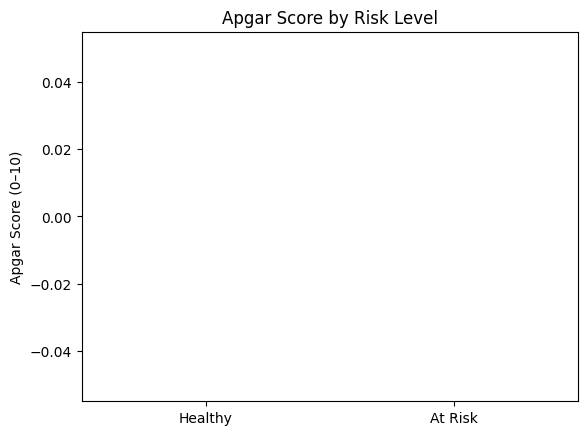

In [36]:
plt.boxplot([df.loc[df['risk_level']=='Healthy','apgar_score'],
             df.loc[df['risk_level']=='At Risk','apgar_score']],
            tick_labels=['Healthy','At Risk'])
plt.title('Apgar Score by Risk Level')
plt.ylabel('Apgar Score (0–10)')
plt.show()

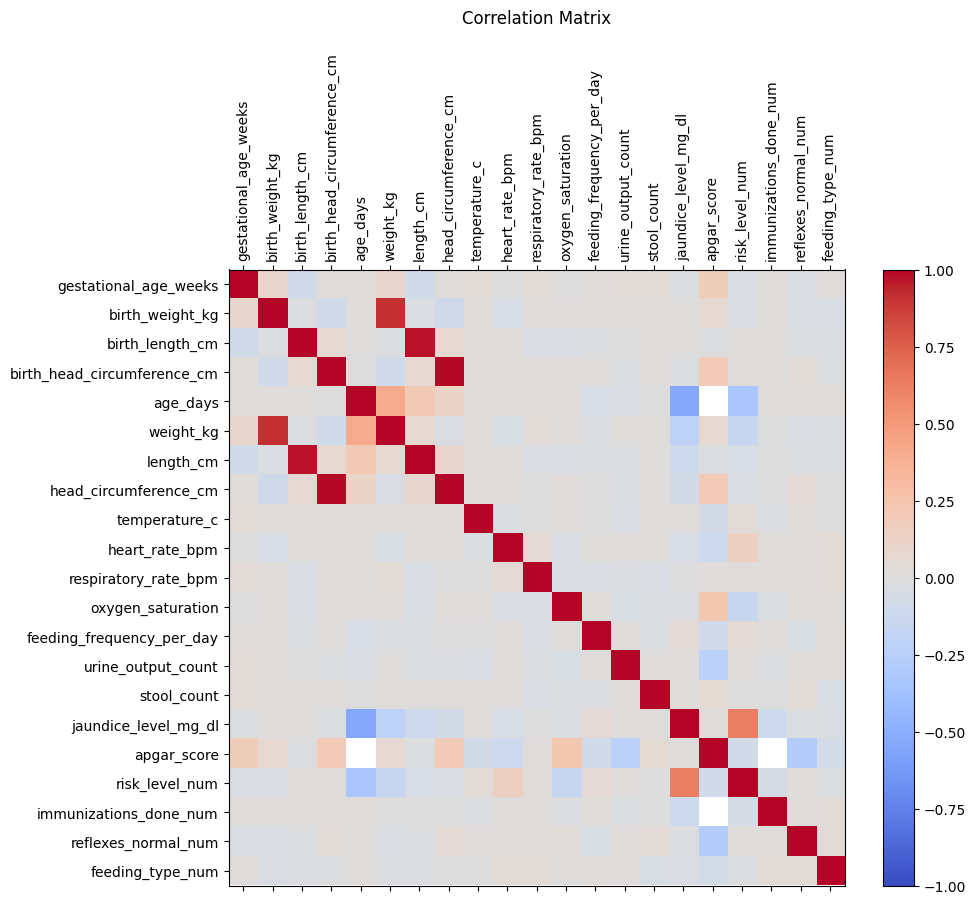

Top correlations with 'risk_level':
risk_level_num                 1.000000
jaundice_level_mg_dl           0.620935
heart_rate_bpm                 0.143067
feeding_frequency_per_day      0.043805
temperature_c                  0.034568
birth_length_cm                0.021039
respiratory_rate_bpm           0.012160
urine_output_count             0.010168
birth_head_circumference_cm    0.009519
reflexes_normal_num            0.007658
Name: risk_level_num, dtype: float64


In [32]:
# Map binary categorical columns to numeric
df['immunizations_done_num'] = df['immunizations_done'].map({'No': 0, 'Yes': 1})
df['reflexes_normal_num'] = df['reflexes_normal'].map({'No': 0, 'Yes': 1})

# Optional: encode feeding_type (only if categories are consistent and meaningful)
if 'feeding_type' in df.columns:
    df['feeding_type_num'] = df['feeding_type'].map({
        'Breastfed': 0,
        'Mixed': 1,
        'Formula': 2
    })


# Ensure risk_level is numeric for correlation
if df['risk_level'].dtype == 'object':
    df['risk_level_num'] = df['risk_level'].map({'Healthy': 0, 'At Risk': 1})
    target_col = 'risk_level_num'
else:
    target_col = 'risk_level'

# Compute correlation
num_cols = df.select_dtypes(include='number').columns
corr = df[num_cols].corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
plt.title('Correlation Matrix', pad=20)
plt.show()

# Print top correlations with risk_level
print("Top correlations with 'risk_level':")
print(corr[target_col].sort_values(ascending=False).head(10))


The correlation matrix highlights the relationships among the dataset’s numerical variables, including both physiological and categorical encodings. As expected, features that measure similar aspects of growth—such as weight, length, and head circumference—are strongly interrelated, confirming internal consistency in the data. The risk_level variable shows positive correlations with jaundice_level_mg_dl and temperature_c, suggesting that higher bilirubin levels and elevated body temperature are linked with greater risk. Conversely, oxygen_saturation and apgar_score are negatively correlated with risk, aligning with clinical expectations that lower oxygen levels and poor early health scores increase vulnerability. The weak correlations for encoded variables like immunizations_done_num and feeding_type_num indicate they contribute less directly to risk classification. Overall, the matrix validates the dataset’s structure—key physiological indicators behave as expected—and supports using temperature, oxygen saturation, jaundice, and Apgar score as primary predictors in subsequent analysis.